# Исследование данных о продажах игр

Интернет-магазин «Стримчик» продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Необходимо выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

В наборе данных попадается аббревиатура ESRB (Entertainment Software Rating Board) — это ассоциация, определяющая возрастной рейтинг компьютерных игр. ESRB оценивает игровой контент и присваивает ему подходящую возрастную категорию, например, «Для взрослых», «Для детей младшего возраста» или «Для подростков».

## Изучение данных

In [1]:
# импортируем необходимые библиотеки

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import warnings

In [2]:
# сохраним данные в виде датафрейма

df = pd.read_csv('games.csv')

In [3]:
# выведем общую информацию о датафрейме

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [4]:
# выведем первые строки данных

df.head(15)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
6,New Super Mario Bros.,DS,2006.0,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E
7,Wii Play,Wii,2006.0,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E
8,New Super Mario Bros. Wii,Wii,2009.0,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN


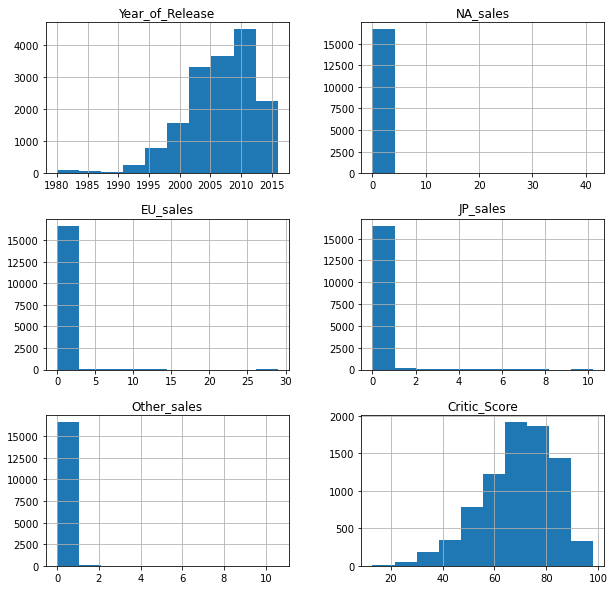

In [5]:
# построим гистограммы для всех столбцов датафрейма с числовыми значениями

df.hist(figsize=(10, 10));

## Предобработка данных

### Переименование столбцов

In [6]:
# переименуем столбцы в соответствии с нижним регистром

df.columns = ['name', 'platform', 'year', 'genre', 'na_sales', 'eu_sales', \
              'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'] 

### Обработка пропусков

In [7]:
# определим количество пропусков в каждом столбце

df.isna().sum()

name               2
platform           0
year             269
genre              2
na_sales           0
eu_sales           0
jp_sales           0
other_sales        0
critic_score    8578
user_score      6701
rating          6766
dtype: int64

Пропуски присутствуют в 6 столбцах из 11. Как мы видим, пропуски в последних трех столбцах затрагивают значительную долю данных - вплоть до половины. Для двух столбцов количество пропусков составляет 2. Проверим, совпадают ли строки с пропусками для данных столбцов.

#### name и genre

In [8]:
# выведем строки с пропусками в столбце name

df[df['name'].isna()]

,name,platform,year,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


In [9]:
# посчитаем отношение данных с пропусками в столбцах name и genre ко всем данным

(len(df[df['name'].isna()]) / len(df)) * 100

0.011965300628178284

Т.к. строки с пропусками в столбцах name и genre составляют совсем незначительную часть данных, будем считать, что их удаление не исказит результаты исследования.

In [10]:
# удалим строки с пропусками в столбцах name и genre

df = df.dropna(subset=['name'])

#### year

Предположим, что год выхода игры зависит от ее платформы.

In [11]:
# выведем датафрейм со средним годом релиза для каждой платформы, отсортированный по году релиза

df.groupby('platform')['year'].mean().sort_values().round().astype('int')

platform
2600    1982
NES     1987
GG      1992
GEN     1993
SCD     1994
SNES    1994
NG      1994
3DO     1995
TG16    1995
GB      1996
PCFX    1996
SAT     1996
PS      1998
N64     1999
DC      2000
WS      2000
GBA     2003
GC      2003
XB      2004
PS2     2005
DS      2008
PSP     2009
PC      2009
Wii     2009
X360    2010
PS3     2011
3DS     2013
WiiU    2014
PSV     2014
XOne    2015
PS4     2015
Name: year, dtype: int32

Действительно, по средним значениям года релиза для каждой платформы просматривается зависимость между двумя данными параметрами.

Данный вывод следует подкрепить логическим рассуждением о характере данных в столбце platform. Среди значений представлены как ярко выраженные "старые" платформы, так и "новые". К "старым" относятся такие платформы как 2600, NES, GG, GEN - средние года релиза для игр на таких платформах достаточно "ранние". "Новые" платформы представлены не в целом - например PS, Xbox - а в нескольких поколениях: PS, PS2, PS3, PS4; XB, X360, XOne. Это удобно тем, что на каждое поколение приходится "свой" средний год релиза игр.

Однако, есть исключение - платформа PC, что значит персональный компьютер, характерна как для "старых" игр, так и для "новых". Проверим, много ли пропусков в year приходится на PC.

In [12]:
# рассчитаем количество пропусков в year для платформы PC

len(
    df[(df['year'].isna()) & (df['platform'] == 'PC')]
)

17

In [13]:
# посчитаем отношение данных с пропусками в столбце year для платформы PC ко всем данным

(len(df[(df['year'].isna()) & (df['platform'] == 'PC')]) / len(df)) * 100

0.10171722611141028

Количество строк с такими пропусками составляет незначительную величину (как абсолютно, так и относительно), а заполнить такие пропуски средним значением не получится. Удалим соответствующие строки.

In [14]:
# удалим строки с пропусками в столбце year для платформы PC

df = df.drop(df[(df['year'].isna()) & (df['platform'] == 'PC')].index)

Для всех прочих платформ мы можем заполнить пропуски в столбце year соответствующими средними значениями для каждой платформы.

In [15]:
# создадим цикл, который заполнит все пропуски в столбце year
# средними значениями year для каждой платформы

for i in df['platform'].unique():
    df.loc[(df['platform'] == i) & (df['year'].isna()), 'year'] = \
    df.groupby('platform')['year'].mean()[i]

In [16]:
# округлим полученные значения

df['year'] = df['year'].round()

#### critic_score

In [17]:
# выведем список уникальных значений столбца critic_score

df['critic_score'].unique()

array([76., nan, 82., 80., 89., 58., 87., 91., 61., 97., 95., 77., 88.,
       83., 94., 93., 85., 86., 98., 96., 90., 84., 73., 74., 78., 92.,
       71., 72., 68., 62., 49., 67., 81., 66., 56., 79., 70., 59., 64.,
       75., 60., 63., 69., 50., 25., 42., 44., 55., 48., 57., 29., 47.,
       65., 54., 20., 53., 37., 38., 33., 52., 30., 32., 43., 45., 51.,
       40., 46., 39., 34., 35., 41., 36., 28., 31., 27., 26., 19., 23.,
       24., 21., 17., 22., 13.])

In [18]:
# выведем строки с пропусками в столбце critic_score

df[df['critic_score'].isna()].head()

,name,platform,year,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN
10,Nintendogs,DS,2005.0,Simulation,9.05,10.95,1.93,2.74,NaN,NaN,NaN


В строках с пропусками в столбце critic_score каких-либо закономерностей не наблюдается. Параметров, которые могут быть напрямую или логически связаны с оценкой критиков, также нет. Все уникальные значения столбца находятся в интервале от 0 до 100, что является нормой.

В таком случае оставим пропуски в данных.

#### user_score

In [19]:
# выведем список уникальных значений столбца user_score

df['user_score'].unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

In [20]:
# выведем строки с пропусками в столбце user_score

df[df['user_score'].isna()].head()

,name,platform,year,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN
10,Nintendogs,DS,2005.0,Simulation,9.05,10.95,1.93,2.74,NaN,NaN,NaN


В строках с пропусками в столбце user_score каких-либо закономерностей не наблюдается. Параметров, которые могут быть напрямую или логически связаны с оценкой пользователей, также нет.

Однако в списке уникальных значений есть интересное значение - 'tbd'. Скорее всего, данная аббревиатура означает 'То Be Defined', что буквально переводится как "подлежит уточнению". Такие значения следует удалить из датафрейма - они могут исказить исследование.

In [21]:
df['user_score'].isna().sum()

6697

In [22]:
# удалим значения 'tbd' в столбце user_score

df.loc[df['user_score'] == 'tbd', 'user_score'] = np.nan

#### rating

In [23]:
# выведем список уникальных значений столбца rating

df['rating'].unique()

array(['E', nan, 'M', 'T', 'E10+', 'K-A', 'AO', 'EC', 'RP'], dtype=object)

In [24]:
# выведем строки с пропусками в столбце rating

df[df['rating'].isna()].head()

,name,platform,year,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN
10,Nintendogs,DS,2005.0,Simulation,9.05,10.95,1.93,2.74,NaN,NaN,NaN


В строках с пропусками в столбце rating каких-либо закономерностей не наблюдается. Параметров, которые могут быть напрямую или логически связаны с рейтингом, также нет. Все уникальные значения столбца выглядят правдоподобно.

В таком случае оставим пропуски в данных.

### Изменение типов данных

In [25]:
# вновь выведем общую информацию о датафрейме

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16696 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   name          16696 non-null  object 
 1   platform      16696 non-null  object 
 2   year          16696 non-null  float64
 3   genre         16696 non-null  object 
 4   na_sales      16696 non-null  float64
 5   eu_sales      16696 non-null  float64
 6   jp_sales      16696 non-null  float64
 7   other_sales   16696 non-null  float64
 8   critic_score  8121 non-null   float64
 9   user_score    7575 non-null   object 
 10  rating        9932 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.5+ MB


Как видно из вывод предыдущей ячейки, все столбцы, за исключением user_score, имеют логически соответствующие типы данных.

Также, в целях экономии памяти, заменим все типы данных float64 на float32.

In [26]:
# изменим типы данных в столбцах

df['user_score'] = df['user_score'].astype('float32')
df['na_sales'] = df['na_sales'].astype('float32')
df['eu_sales'] = df['eu_sales'].astype('float32')
df['jp_sales'] = df['jp_sales'].astype('float32')
df['other_sales'] = df['other_sales'].astype('float32')
df['critic_score'] = df['critic_score'].astype('float32')

### Обработка дубликатов

#### Явные дубликаты

In [27]:
# проверим наличие явных дубликатов в датафрейме

df.duplicated().sum()

0

In [28]:
# проверим наличие дубликатов в столбце name

df['name'].duplicated().sum()

5140

In [29]:
# выведем соответствующие строки

df[df['name'].duplicated()].head(20)

,name,platform,year,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
23,Grand Theft Auto V,X360,2013.0,Action,9.66,5.14,0.06,1.41,97.0,8.1,M
35,Call of Duty: Black Ops II,X360,2012.0,Shooter,8.25,4.24,0.07,1.12,83.0,4.8,M
37,Call of Duty: Modern Warfare 3,PS3,2011.0,Shooter,5.54,5.73,0.49,1.57,88.0,3.2,M
41,Call of Duty: Black Ops,PS3,2010.0,Shooter,5.99,4.37,0.48,1.79,88.0,6.4,M
42,Grand Theft Auto V,PS4,2014.0,Action,3.96,6.31,0.38,1.97,97.0,8.3,M
55,Call of Duty: Modern Warfare 2,PS3,2009.0,Shooter,4.99,3.64,0.38,1.60,94.0,6.3,M
57,Grand Theft Auto IV,PS3,2008.0,Action,4.76,3.69,0.44,1.61,98.0,7.5,M
59,Super Mario 64,DS,2004.0,Platform,5.01,3.07,1.25,0.97,NaN,NaN,NaN
69,Call of Duty: Ghosts,PS3,2013.0,Shooter,4.10,3.63,0.38,1.25,71.0,2.6,M
99,Call of Duty: Black Ops 3,XOne,2015.0,Shooter,4.59,2.11,0.01,0.68,NaN,NaN,NaN


In [30]:
# выведем строки с игрой Grand Theft Auto V

df.query('name == "Grand Theft Auto V"')

,name,platform,year,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
16,Grand Theft Auto V,PS3,2013.0,Action,7.02,9.09,0.98,3.96,97.0,8.2,M
23,Grand Theft Auto V,X360,2013.0,Action,9.66,5.14,0.06,1.41,97.0,8.1,M
42,Grand Theft Auto V,PS4,2014.0,Action,3.96,6.31,0.38,1.97,97.0,8.3,M
165,Grand Theft Auto V,XOne,2014.0,Action,2.81,2.19,0.00,0.47,97.0,7.9,M
1730,Grand Theft Auto V,PC,2015.0,Action,0.39,0.69,0.00,0.09,96.0,7.9,M


Как мы видим, хотя в столбце name и присутствуют дубликаты, однако их наличие связано с тем, что одна и та же игра может выходить на разных платформах.

#### Неявные дубликаты

Проверим наличие неявных дубликатов по значениям из столбцов с типом данных object.

In [31]:
print('Количество уникальных значений в столбцах:')
print('name -  ',  df['name'].nunique())
print('platform -  ',  df['platform'].nunique())
print('genre -  ',  df['genre'].nunique())

Количество уникальных значений в столбцах:
name -   11556
platform -   31
genre -   12


Неявных дубликатов не обнаружено.

### Добавление новых столбцов

Добавим в датафрейм столбец с суммарными продажами игр во всех регионах.

In [32]:
df['total_sales'] = df['na_sales'] + df['eu_sales'] + df['jp_sales'] + df['other_sales']

### Обработка аномальных значений

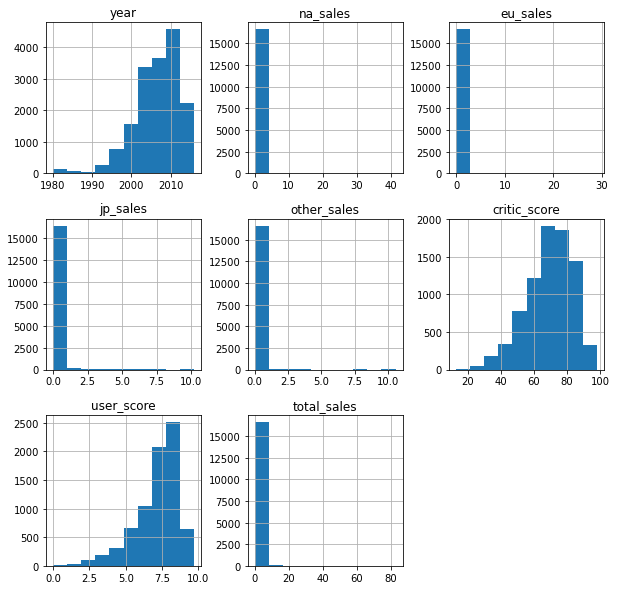

In [33]:
# построим гистограммы для всех столбцов обновленного датафрейма с числовыми значениями

df.hist(figsize=(10, 10));

По гистограммам видно, что в столбцах с продажами присутствуют аномалии. Обработаем их.

#### na_sales

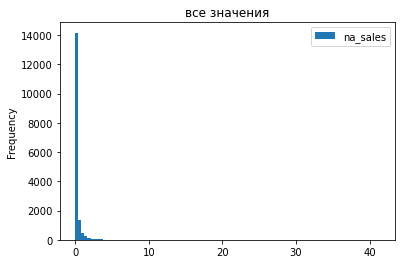

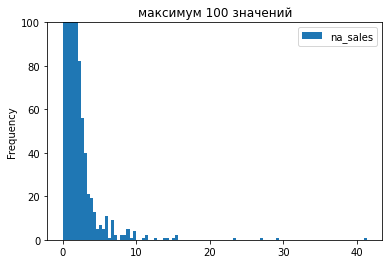

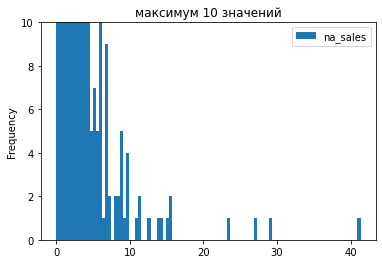

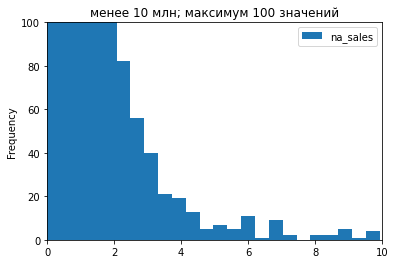

In [34]:
# построим более наглядные гистограммы для столбца na_sales

df.plot(y=('na_sales'), kind='hist', bins=100, title='все значения');

df.plot(y=('na_sales'), kind='hist', bins=100, ylim=(0, 100), title='максимум 100 значений');

df.plot(y=('na_sales'), kind='hist', bins=100, ylim=(0, 10), title='максимум 10 значений');

df.plot(y=('na_sales'), kind='hist', bins=100, xlim=(0, 10), ylim=(0, 100),
        title='менее 10 млн; максимум 100 значений');

In [35]:
# посчитаем количество строк датафрейма со значением na_sales более 6 миллионов проданных копий

len(df.query('na_sales > 6'))

43

In [36]:
# посчитаем отношение таких данных к ненулевым данным

(len(df.query('na_sales > 6')) / len(df.query('na_sales > 0'))) * 100

0.35260352603526035

Значения более 6 миллионов проданных копий являются аномалиями. Также стоит отметить, что таких значений в датафрейме немного. Удалим соответствующие строки.

In [37]:
# удалим строки с аномалиями в столбце na_sales

df = df.drop(df[df['na_sales'] > 6].index)

#### eu_sales

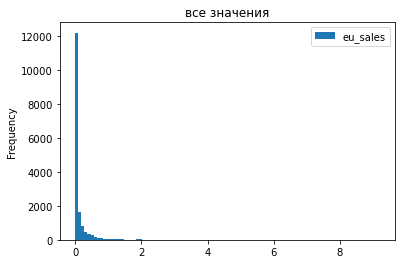

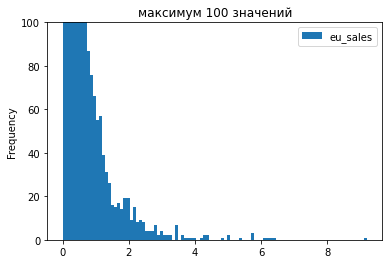

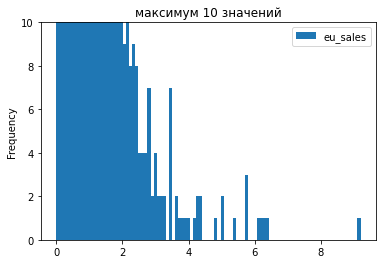

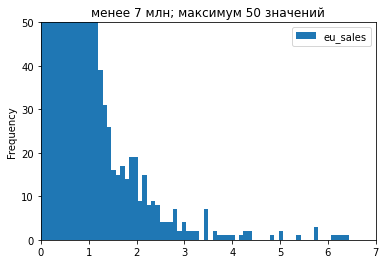

In [38]:
# построим более наглядные гистограммы для столбца eu_sales

df.plot(y=('eu_sales'), kind='hist', bins=100, title='все значения');

df.plot(y=('eu_sales'), kind='hist', bins=100, ylim=(0, 100), title='максимум 100 значений');

df.plot(y=('eu_sales'), kind='hist', bins=100, ylim=(0, 10), title='максимум 10 значений');

df.plot(y=('eu_sales'), kind='hist', bins=100, xlim=(0, 7), ylim=(0, 50),
        title='менее 7 млн; максимум 50 значений');

In [39]:
# посчитаем количество строк датафрейма со значением eu_sales более 3 миллионов проданных копий

len(df.query('eu_sales > 2'))

114

In [40]:
# посчитаем отношение таких данных к ненулевым данным

(len(df.query('eu_sales > 2')) / len(df.query('eu_sales > 0'))) * 100

1.0570236439499305

Значения более 2 миллионов проданных копий являются аномалиями. Также стоит отметить, что таких значений в датафрейме немного. Удалим соответствующие строки.

In [41]:
# удалим строки с аномалиями в столбце eu_sales

df = df.drop(df[df['eu_sales'] > 2].index)

#### jp_sales

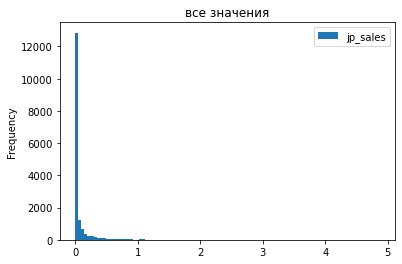

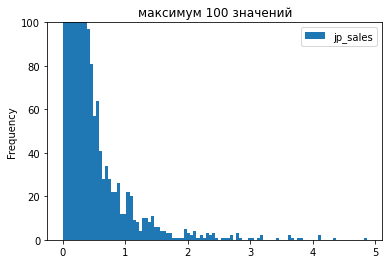

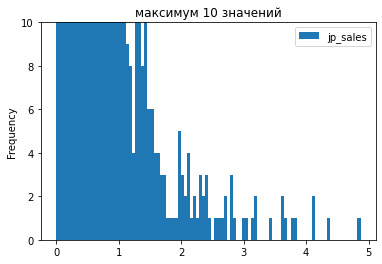

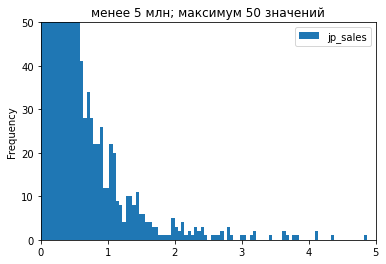

In [42]:
# построим более наглядные гистограммы для столбца jp_sales

df.plot(y=('jp_sales'), kind='hist', bins=100, title='все значения');

df.plot(y=('jp_sales'), kind='hist', bins=100, ylim=(0, 100), title='максимум 100 значений');

df.plot(y=('jp_sales'), kind='hist', bins=100, ylim=(0, 10), title='максимум 10 значений');

df.plot(y=('jp_sales'), kind='hist', bins=100, xlim=(0, 5), ylim=(0, 50),
        title='менее 5 млн; максимум 50 значений');

In [43]:
# посчитаем количество строк датафрейма со значением jp_sales более 1.7 миллионов проданных копий

len(df.query('jp_sales > 1.7'))

58

In [44]:
# посчитаем отношение таких данных к ненулевым данным

(len(df.query('jp_sales > 1.7')) / len(df.query('jp_sales > 0'))) * 100

0.957095709570957

Значения более 1.7 миллионов проданных копий являются аномалиями. Также стоит отметить, что таких значений в датафрейме немного. Удалим соответствующие строки.

In [45]:
# удалим строки с аномалиями в столбце jp_sales

df = df.drop(df[df['jp_sales'] > 1.7].index)

#### other_sales

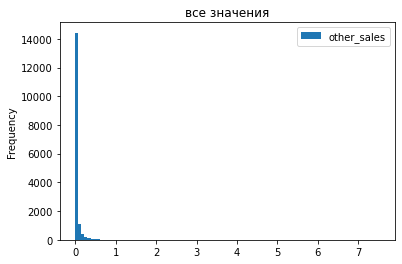

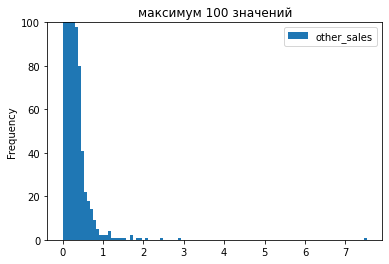

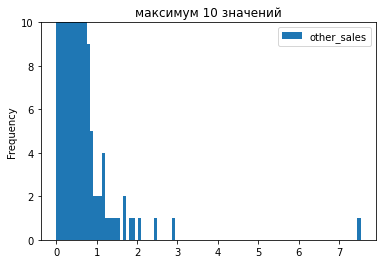

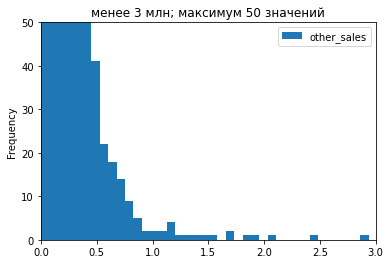

In [46]:
# построим более наглядные гистограммы для столбца other_sales

df.plot(y=('other_sales'), kind='hist', bins=100, title='все значения');

df.plot(y=('other_sales'), kind='hist', bins=100, ylim=(0, 100), title='максимум 100 значений');

df.plot(y=('other_sales'), kind='hist', bins=100, ylim=(0, 10), title='максимум 10 значений');

df.plot(y=('other_sales'), kind='hist', bins=100, xlim=(0, 3), ylim=(0, 50),
        title='менее 3 млн; максимум 50 значений');

In [47]:
# посчитаем количество строк датафрейма со значением other_sales более 0.6 миллиона проданных копий

len(df.query('other_sales > .6'))

69

In [48]:
# посчитаем отношение таких данных к ненулевым данным

(len(df.query('other_sales > .6')) / len(df.query('other_sales > 0'))) * 100

0.6968993031006969

Значения более 0.6 миллиона проданных копий являются аномалиями. Также стоит отметить, что таких значений в датафрейме немного. Удалим соответствующие строки.

In [49]:
# удалим строки с аномалиями в столбце other_sales

df = df.drop(df[df['other_sales'] > .6].index)

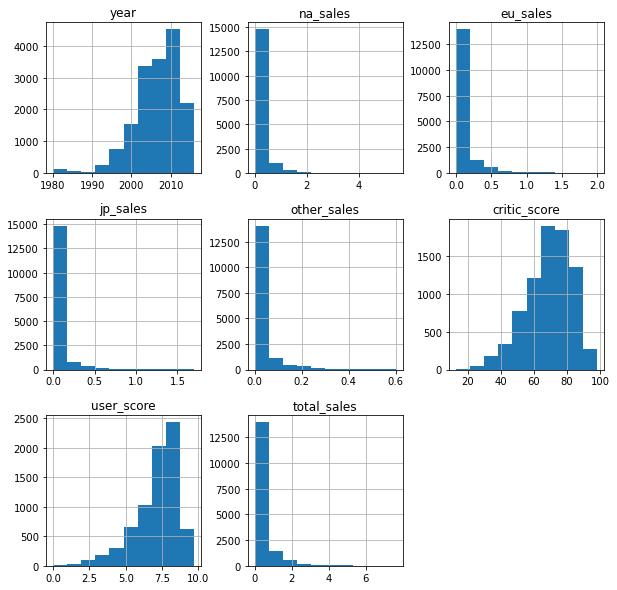

In [50]:
# вновь построим гистограммы для всех столбцов датафрейма с числовыми значениями

df.hist(figsize=(10, 10));

## Исследовательский анализ данных

### Анализ релиза игр по годам

In [51]:
print('Минимальный год релиза -', df['year'].min())
print('Максимальный год релиза -', df['year'].max())

Минимальный год релиза - 1980.0
Максимальный год релиза - 2016.0


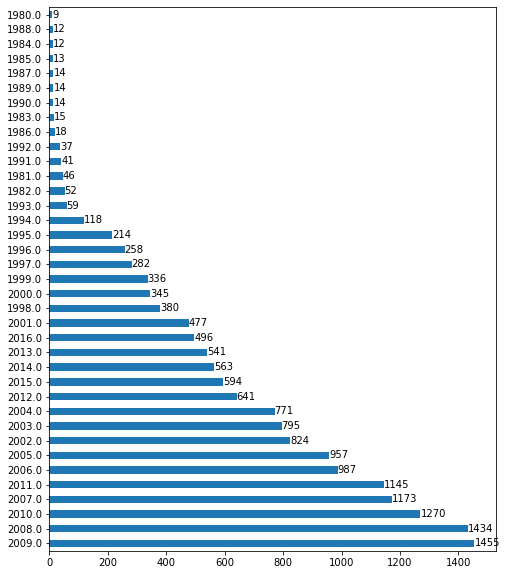

In [52]:
ax = df['year'].value_counts().plot(kind='barh', figsize=(8,10))

pl = ax.bar_label(ax.containers[0])

In [53]:
# выведем отношение числа игр, выпущенных в период с 2005 по 2012 год, к общему числу игр

len(df.query('2001 < year < 2012')) / len(df)

0.6587253229344382

In [54]:
print('Cреднее количество игр, выпущенных за один год   ', round(df['year'].value_counts().mean(), 1))
print('Медианное количество игр, выпущенных за один год ', df['year'].value_counts().median())

Cреднее количество игр, выпущенных за один год    443.6
Медианное количество игр, выпущенных за один год  336.0


In [55]:
# рассчитаем количество игр, выпущенных в 80-e годы

print('Количество игр, выпущенных в 80-e годы:        ', len(df.query('1980 < year < 1989')))
print('Количество игр, выпущенных в 90-e годы:        ', len(df.query('1990 < year < 1999')))
print('Количество игр, выпущенных в 00-e годы:        ', len(df.query('2000 < year < 2009')))
print('Количество игр, выпущенных с 2010 по 2016 года:', len(df.query('2010 < year < 2016')))

Количество игр, выпущенных в 80-e годы:         182
Количество игр, выпущенных в 90-e годы:         1389
Количество игр, выпущенных в 00-e годы:         7418
Количество игр, выпущенных с 2010 по 2016 года: 3484


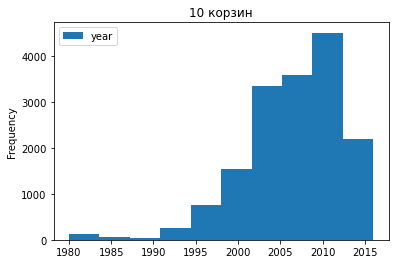

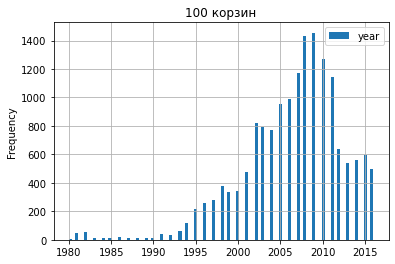

In [56]:
# построим гистограммы для столбца year

df.plot(y='year', kind='hist', bins=10, title='10 корзин');
df.plot(y='year', kind='hist', bins=100, title='100 корзин', grid=True);

Мы получили следуюшие данные:
- в датафрейме представлены данные о релизах игр с 1980 по 2016 года включительно;
- наибольшее количество игр было выпущено в 2009 году - почти 1500, наименьшее - в 1980 - 9;
- среднее количество игр, выпущенных за один год, составляет 444;
- медианное количество игр, выпущенных за один год, составляет 336;
- в 80-е годы было выпущено 182 игры, в 90-е - 1389, в 00-е - 7418, с 2010 по 2016 года - 3484.

**По полученным данным можно сделать следующие выводы**:
- начиная с 2002 года заметен скачок количества выпущенных за год игр: вплоть до 2011 года этот параметр составляет не менее 750;
- кроме того, в период с 2002 по 2011 года были выпущены две трети игр;
- до 2011 года включительно наблюдается тенденция к увеличению количества выпущенных за год игр, после - тенденция к уменьшению;
- в связи с полученными данными можно выделить 5 временных периодов:
 - 1980-1993 - период становления игровой индустрии: ежегодно выходят не более 60 игр;
 - 1994-2001 - период бурного роста: количество выпускаемых игр увеличивается со 118 до 477;
 - 2002-2009 - "золотой" период индустрии: в год выпускается не менее 750 игр, в период с 2005 года - не менее 800, с 2007 - не менее 1000; пик приходится на 2009 год - почти 1.5 тысячи выпущенных игр;
 - 2010-2011 - период плавного спада: за 2010 год выходит менее 1300 игр, за 2011 - менее 1200;
 - 2012-2016 - период резкого спада: в 2012 году выходит 641 игра, далее - менее 600 игр в год.





### Анализ продаж по платформам

In [57]:
# выведем отсортированный сириэс с суммарными продажами игр для каждой платформы

(
    df.groupby('platform')['total_sales'].sum()
    .sort_values(ascending=False)
)

platform
PS2     996.409973
X360    751.739990
PS3     667.020020
PS      623.220032
DS      566.229980
Wii     551.229980
GBA     285.100006
XB      249.259995
PSP     242.569992
PC      224.110001
GC      198.929993
PS4     184.740005
N64     183.259995
3DS     148.600006
XOne    140.559998
NES     131.229996
SNES    113.479996
GB      110.510002
2600     89.169998
WiiU     75.099998
PSV      54.070000
SAT      33.590000
GEN      28.350000
DC       15.950000
SCD       1.860000
NG        1.440000
WS        1.420000
TG16      0.160000
3DO       0.100000
GG        0.040000
PCFX      0.030000
Name: total_sales, dtype: float32

Сделаем предположение о том, что средние года релиза игр для платформ с наибольшими суммарными продажами игр лежат ближе к нашему времени.

In [58]:
# сохраним сириэс в переменную

top_sales_platforms = df.groupby('platform')['total_sales'].sum().sort_values(ascending=False)

In [59]:
# напишем цикл, который запишет значение среднего года релиза игры для каждой платформы

for i in df['platform'].unique():
    top_sales_platforms[i] = df[df['platform'] == i]['year'].mean()

In [60]:
top_sales_platforms

platform
PS2     2004.575073
X360    2009.875000
PS3     2010.867554
PS      1998.006836
DS      2008.195312
Wii     2008.974609
GBA     2003.207520
XB      2003.645142
PSP     2008.753296
PC      2008.945312
GC      2003.390259
PS4     2015.167114
N64     1998.555542
3DS     2013.120972
XOne    2014.950562
NES     1987.333374
SNES    1993.875610
GB      1996.068237
2600    1982.121216
WiiU    2013.657593
PSV     2014.132568
SAT     1996.028931
GEN     1993.036987
DC      1999.942261
SCD     1993.833374
NG      1994.500000
WS      2000.000000
TG16    1995.000000
3DO     1994.666626
GG      1992.000000
PCFX    1996.000000
Name: total_sales, dtype: float32

Как мы видим, предположение оправдалось: средние года релиза для 10 из топ 11 платформ с наибольшими суммарными продажами игр лежат в промежутке между 2003 и 2011 годами - в этот период было выпущено подавляющее большинство игр. Мы можем сделать вывод о связи между количеством проданных копий игры и платформой выхода игры (которая, в свою очередь, связана с годом выхода игры).

<AxesSubplot:xlabel='platform'>

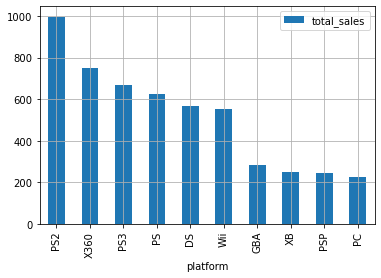

In [61]:
# построим столбчатую диаграмму для датафрейма с суммарными продажами игр
# для каждой платформы для значений более 200 миллионов проданных копий

(
    pd.DataFrame(df.groupby('platform')['total_sales'].sum().sort_values(ascending=False))
    .query('total_sales > 200')
    .plot(y='total_sales', kind='bar', grid=True)
)

Построим графики распределения по годам (столбчатые диаграммы) для платформ с наибольшими суммарными продажами игр, а именно для PS2, X360, PS3, PS, DS и Wii, как для платформ с количеством проданных копий игр более 500 миллионов.

Из столбчатых диаграмм видно, что для всех платформ из топ 6, кроме PS, пики на графиках приходятся на период с 2003 по 2011 года, когда было выпущено преобладающее число игр.

Также по графикам заметно, что **в данных наблюдается характерный срок, когда появляются новые платформы и исчезают старые: этот срок составляет 8-11 лет**.

### Определение актуального периода

Исходя из предыдущих двух анализов можно сделать вывод о том, что за актуальный период следует принять такой промежуток времени, который будет соответствовать следующим условиям:
- года внутри промежутка будут находится вместе с прогнозируемым 2017 годом в одном периоде (из вывода анализа релиза игр по годам), а именно в периоде резкого спада: 2012-2016;
- года внутри промежутка должны стать годами первых релизов игр на новых платформах - это связано с тем, что срок появления и исчезновения платформ составляет 8-11 лет.

На основе данных за соответствующий актуальный период можно будет сделать прогноз на 2017 год, т.к:
- года будет принадлежать одному периоду развития индустрии, следовательно, релизы и продажи должны будут осуществляться по одному закону;
- в 2017 году продолжат выходить игры на новых платформах, срок жизни которых еще не истечет.

Проверим, выходили ли релизы на новых платформах в период с 2012 года.

In [62]:
# выведем список годов, в которые произошли первые релизы на новых платформах

df.groupby('platform')['year'].min().sort_values(ascending=False)

platform
XOne    2013.0
PS4     2013.0
WiiU    2012.0
3DS     2011.0
PSV     2011.0
PS3     2006.0
Wii     2006.0
X360    2005.0
PSP     2004.0
GC      2001.0
GBA     2000.0
PS2     2000.0
XB      2000.0
WS      1999.0
DC      1998.0
PCFX    1996.0
N64     1996.0
TG16    1995.0
SAT     1994.0
PS      1994.0
3DO     1994.0
SCD     1993.0
NG      1993.0
GG      1992.0
SNES    1990.0
GEN     1990.0
GB      1988.0
PC      1985.0
DS      1985.0
NES     1983.0
2600    1980.0
Name: year, dtype: float64

Учитывая вышеописанные условия, **в качестве актуального периода принимаем промежуток с 2012 по 2016 год включительно**.

**Перезапишем датафрейм, оставив в нем данные исключительно за актуальный период**.

In [63]:
df = df.query('year > 2011')

### Исследование прибыльности платформ

In [64]:
# выведем сириэс с платформами по наибольшим продажам игр

df.groupby('platform')['total_sales'].sum().sort_values(ascending=False)

platform
PS3     200.399994
PS4     184.740005
X360    168.080002
XOne    140.559998
3DS     111.639999
WiiU     75.099998
PC       57.509998
PSV      49.439999
Wii      28.610001
PSP      11.190000
DS        4.490000
Name: total_sales, dtype: float32

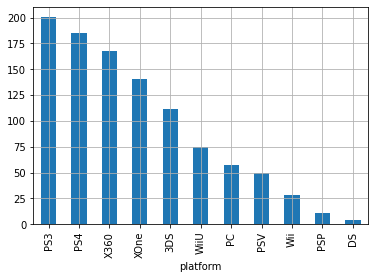

In [65]:
# построим столбчатую диаграмму для полученных данных

(
    df.groupby('platform')['total_sales'].sum().sort_values(ascending=False)
    .plot(y='total_sales', kind='bar', grid=True)
);

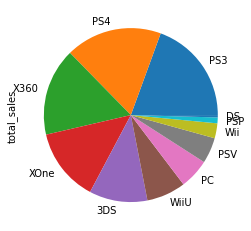

In [66]:
# построим круговую диаграмму для полученных данных

(
    df.groupby('platform')['total_sales'].sum().sort_values(ascending=False)
    .plot(y='total_sales', kind='pie', grid=True)
);

**Построим столбчатые диаграммы для платформ с числом продаж более 50 миллионов копий - именно такие платформы являются лидерами по продажам**.

Однако следует учесть, что ввиду общего падения игровой индустрии в течение актуального периода строить графики по абсолютным величинам продаж будет некорректно. В таком случае построим столбчатые диаграммы для каждой платформы по доле продаж по годам.

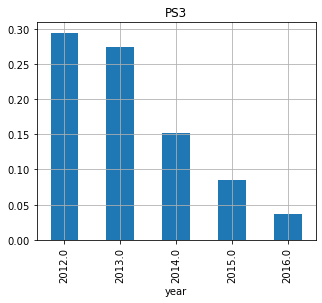

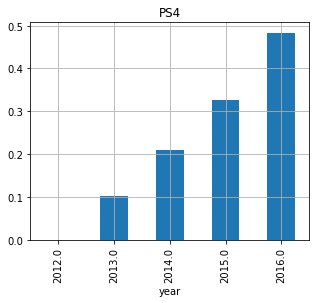

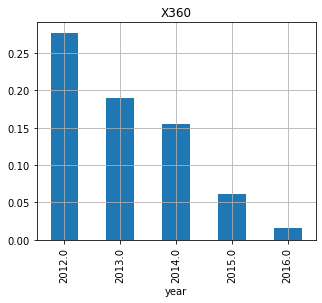

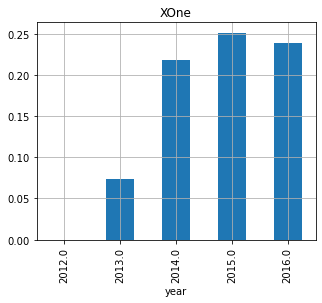

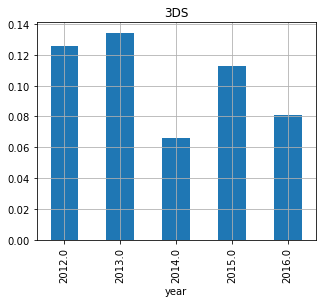

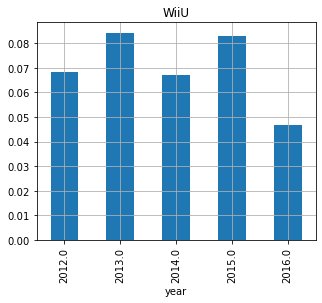

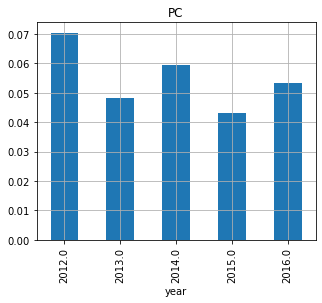

In [67]:
def plot_diagram(platform):
    (
        (
            (df.query('platform == "{}"'.format(platform)).groupby('year')['total_sales'].sum()) /
            (df.groupby('year')['total_sales'].sum())
        )
        .plot(y='total_sales', kind='bar', grid=True, title=platform, figsize=(5, 4))
    );
    
platforms_to_plot_diag = ['PS3','PS4','X360','XOne','3DS','WiiU','PC']

for plat in platforms_to_plot_diag:
    plot_diagram(plat)
    plt.show()

Из полученных диаграмм видно, что представленные платформы можно разбить на следующие группы:
- платформы, жизненный цикл которых подходит к концу - продажи падают:
 - PS3
 - X360
- платформы, жизненный цикл которых берет свое начало - продажи растут:
 - PS4
 - XOne
- платформы, для которых не наблюдается четкой тенденции к падению или росту продаж:
 - 3DS
 - WiiU
 - PC
 
Логично предположить, что **потенциально прибыльными платформами можно считать оные, относящиеся к группе роста продаж, а именно PS4 и XOne**.

### Анализ характера разброса данных

Построим диаграммы размаха ("ящики с усами") по продажам игр для каждой платформы.

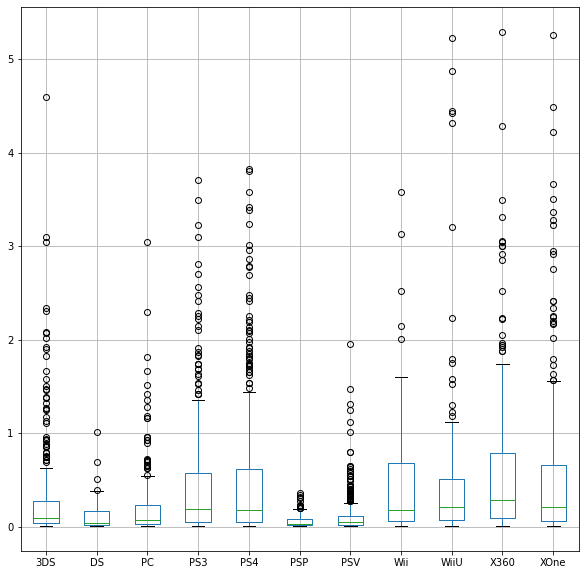

In [68]:
(
    df
    .pivot_table(index=['name', 'genre', 'na_sales'], columns='platform', values='total_sales')
    .boxplot(figsize=(10, 10))
);

In [69]:
# выведем общую статистическую информацию по продажам игр для каждой платформы

for i in df['platform'].unique():
    print(i, '\n')
    print(df[df['platform'] == i]['total_sales'].describe(), '\n\n')

X360 

count    285.000000
mean       0.589754
std        0.763973
min        0.010000
25%        0.100000
50%        0.290000
75%        0.790000
max        5.290000
Name: total_sales, dtype: float64 


XOne 

count    243.000000
mean       0.578436
std        0.870649
min        0.010000
25%        0.060000
50%        0.210000
75%        0.660000
max        5.260000
Name: total_sales, dtype: float64 


WiiU 

count    146.000000
mean       0.514383
std        0.912521
min        0.010000
25%        0.080000
50%        0.210000
75%        0.517500
max        5.230000
Name: total_sales, dtype: float64 


3DS 

count    391.000000
mean       0.285524
std        0.496274
min        0.010000
25%        0.040000
50%        0.100000
75%        0.280000
max        4.590000
Name: total_sales, dtype: float64 


PS4 

count    371.000000
mean       0.497951
std        0.740075
min        0.010000
25%        0.050000
50%        0.180000
75%        0.615000
max        3.830000
Name: total_sales, 

**По полученным данным можно сделать следующие выводы**:
- медианы продаж игр для платформ лежат в интервале от 30 тысяч до 290 тысяч;
- первые квартили находятся достаточно близко друг к другу: наименьшее значение составляет 20 тысяч, наибольшее - 100 тысяч;
- третьи квартили достаточно широко разбросаны: наименьшее значение - 90 тысяч, наибольшее - 790 тысяч;
- распределение границ статистически значимой выборки имеет схожую с распределением квартилей природу: нижние границы расположены близко друг к другу, верхние - разбросаны и находятся в промежутке между ~180 тысячами и 1750 тысячми;
- для всех платформ наблюдаются выбросы: для PSP все они лежат в интервале до 500 тысяч, для WiiU, X360 и XOne отдельные значения превышают 5 миллионов;
- данные для некоторых платформ (PSP, PSV, DS) сгруппированы достаточно плотно, для других (X360, Wii, XOne) - достаточно широко разбросаны;
- для графиков всех платформ характерна асимметрия - медиана значительно ближе расположена к первому квартилю, нежели к третьему;
- в целом данные смещены в сторону нижней границы значений.

### Исследование влияния отзывов пользователей и критиков на продажи

Для каждой пары параметров - общие продажи-оценка критиков и общие продажи-оценка пользователей - построим диаграммы рассеяния для случайной популярной растущей платформы, а также рассчитаем коэффициенты корреляции.

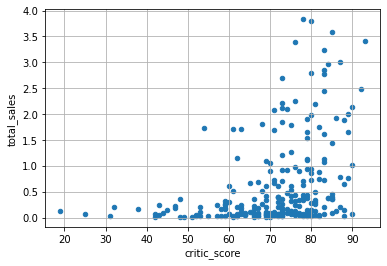

In [70]:
# построим диаграмму рассеяния для столбцов total_sales и critic_score для платформы PS4

df.query('platform == "PS4"').plot(y='total_sales', x='critic_score', kind='scatter', grid=True);

In [71]:
# вычислим коэффициент корреляции Пирсона для столбцов total_sales и critic_score

df['total_sales'].corr(df['critic_score'])

0.3346236607070811

In [72]:
# вычислим коэффициент корреляции Пирсона для столбцов total_sales и critic_score для платформы PS4

df.query('platform == "PS4"')['total_sales'].corr(df['critic_score'])

0.37322929481260897

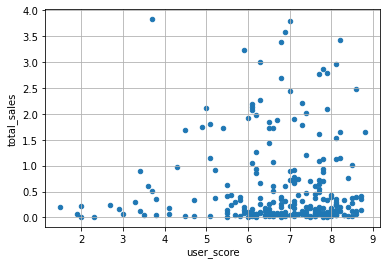

In [73]:
# построим диаграмму рассеяния для столбцов total_sales и user_score для платформы PS4

df.query('platform == "PS4"').plot(y='total_sales', x='user_score', kind='scatter', grid=True);

In [74]:
# вычислим коэффициент корреляции Пирсона для столбцов total_sales и user_score

df['total_sales'].corr(df['user_score'])

0.040189171411949116

In [75]:
# вычислим коэффициент корреляции Пирсона для столбцов total_sales и user_score для платформы PS4

df.query('platform == "PS4"')['total_sales'].corr(df['user_score'])

0.005062862349403954

Выводы:
- по графикам нельзя сделать однозначный вывод о наличии взаимосвязи между исследуемыми параметрами: на обоих графиках заметно, что игры с продажами до 500 тысяч копий встречаются довольно часто по всей оси абсцисс: вне зависимости от оценки критиков/пользователей;
- тем не менее, игры с количеством проданных копий более 1.5 миллиона имеют оценку критиков не менее 50, а игры с продажами более 2 миллионов - не менее 70;
- коэффициент корреляции Пирсона для пары параметров: общие продажи-оценка критиков составляет 33 процента, что говорит о наличии умеренной связи. Однако данный показатель достаточно мал для того, чтобы сделать вывод о наличии высокой или хотя бы заметной связи между исследуемыми параметрами;
- коэффициент корреляции Пирсона для пары параметров: общие продажи-оценка пользователей составляет 0.4 процента, что говорит либо об отсутствии взаимосвязи между исследуемыми параметрами, либо о ее более сложном характере;
- аналогичные коэффициенты корреляции для данных для платформы PS4 не сильно отличаются от оных, рассчитанных ранее.

Общий вывод: полученные данные говорят о том, что **утверждать о влиянии отзывов пользователей и критиков на продажи нельзя**.

### Исследование прибыльности жанров

In [76]:
# выведем сириэс с жанрами по количеству игр

df['genre'].value_counts()

Action          1017
Role-Playing     361
Adventure        303
Sports           260
Shooter          220
Misc             188
Racing           115
Fighting         108
Platform          84
Simulation        80
Strategy          71
Puzzle            28
Name: genre, dtype: int64

<AxesSubplot:>

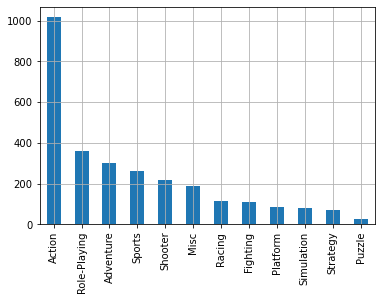

In [77]:
# для полученных данных построим столбчатую диаграмму

(
    df['genre'].value_counts()
    .plot(kind='bar', grid=True)
)

Однозначным лидером среди жанров по количеству игр является action: на него приходится более 1000 наименований. На следующие следом за ним Role-Playing, Adventure, Sports и Shooter приходятся от 360 до 220 игр соответственно, что составляет значительную разницу в сравнении с количеством игр для action.

Внизу топа располагаются жанры Puzzle, Strategy и Simulation с 28, 71 и 80 выпущенными играми соответственно.

Изучим распределение прибыли по жанрам.

In [78]:
# выведем датафрейм с жанрами по продажам игр

(
    df.groupby('genre')['total_sales'].sum()
    .sort_values(ascending=False)
)

genre
Action          333.559998
Shooter         179.039993
Sports          134.100006
Role-Playing    122.040001
Misc             59.509998
Platform         51.100002
Racing           46.500000
Fighting         36.939999
Adventure        29.520000
Simulation       21.219999
Strategy         13.340000
Puzzle            4.890000
Name: total_sales, dtype: float32

<AxesSubplot:xlabel='genre'>

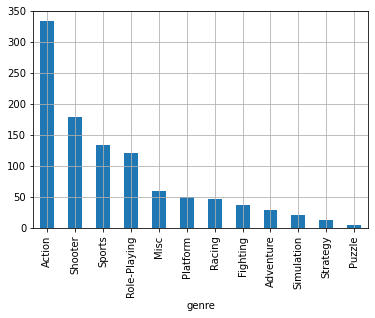

In [79]:
# для полученных данных построим столбчатую диаграмму

(
    df.groupby('genre')['total_sales'].sum()
    .sort_values(ascending=False)
    .plot(kind='bar', grid=True)
)

В данных по продажам игр среди всех жанров вновь выделяется action: в мире продано более 330 миллионов копий игр данного жанра.
Также более 100 миллионов копий игр продано для жанров Shooter, Sports и Role-Playing (180, 135 и 120 миллионов соответственно). Следует отметить, что все жанры из топ 4 по продажам также входят в топ 5 по количеству выпущенных игр.

Внизу данного топа располагаются жанры Puzzle, Strategy и Simulation с 5, 13 и 21 миллионом проданных копий соответственно. Расположение данных жанров в топе полностью соответствует их расположению в топе по количеству выпущенных игр.

Из полученных данных можно сделать вывод о том, что среди жанров выделяются как оные с высокими продажами, так и с низкими.

**К группе жанров с высоким уровнем продаж относятся**:
- Action
- Shooter
- Sports
- Role-Playing

**К группе жанров с низким уровнем продаж относятся**:
- Puzzle
- Strategy
- Simulation

Из полученных данных можно сделать вывод о зависимости между количеством выпущенных игр и их суммарными продажами. Кроме того, в ходе исследования были определены потенциально прибыльные жанры: оные, относящиеся к группе с высоким уровнем продаж, а именно: Action, Shooter, Sports и Role-Playing.

### Исследование пользователей по регионам

#### Топ 5 популярных платформ

Выведем топ 5 платформ по количеству проданных копий игр для Северной Америки, Европы и Японии.

In [80]:
print('Северная Америка')

display(
    df.groupby('platform')['na_sales'].sum()
    .sort_values(ascending=False)
    .head()
)

print('Европа')

display(
    df.groupby('platform')['eu_sales'].sum()
    .sort_values(ascending=False)
    .head()
)

print('Япония')

(
    df.groupby('platform')['jp_sales'].sum()
    .sort_values(ascending=False)
    .head()
)

Северная Америка


platform
X360    101.050003
XOne     84.400002
PS3      75.330002
PS4      66.599998
WiiU     34.950001
Name: na_sales, dtype: float32

Европа


platform
PS4     77.400002
PS3     65.440002
X360    51.290001
XOne    43.119999
PC      35.599998
Name: eu_sales, dtype: float32

Япония


platform
3DS     49.939999
PS3     32.310001
PSV     21.110001
PS4     12.780000
WiiU    11.730000
Name: jp_sales, dtype: float32

Посчитаем доли продаж для топ 5 платформ относительно всего регионального рынка для Северной Америки, Европы и Японии.

In [81]:
print('Северная Америка')

display(
    (df.groupby('platform')['na_sales'].sum()
    .sort_values(ascending=False)
    .head()) * 100 /
    df['na_sales'].sum()
)

print('Европа')

display(
    (df.groupby('platform')['eu_sales'].sum()
    .sort_values(ascending=False)
    .head()) * 100 /
    df['eu_sales'].sum()
)

print('Япония')

display(
    (df.groupby('platform')['jp_sales'].sum()
    .sort_values(ascending=False)
    .head()) * 100 /
    df['jp_sales'].sum()
)

Северная Америка


platform
X360    23.070776
XOne    19.269407
PS3     17.198629
PS4     15.205480
WiiU     7.979452
Name: na_sales, dtype: float32

Европа


platform
PS4     22.547192
PS3     19.063156
X360    14.941156
XOne    12.561174
PC      10.370543
Name: eu_sales, dtype: float32

Япония


platform
3DS     34.695011
PS3     22.446854
PSV     14.665833
PS4      8.878699
WiiU     8.149229
Name: jp_sales, dtype: float32

Также выведем круговые диаграммы топ 5 платформ по количеству проданных копий игр для Северной Америки, Европы и Японии.

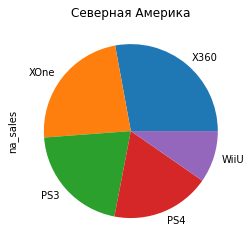

In [82]:
(
    df.groupby('platform')['na_sales'].sum()
    .sort_values(ascending=False)
    .head()
    .plot(kind='pie', grid=True, title='Северная Америка')
);

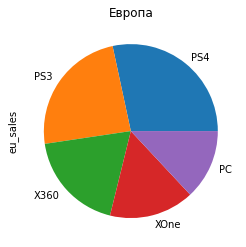

In [83]:
(
    df.groupby('platform')['eu_sales'].sum()
    .sort_values(ascending=False)
    .head()
    .plot(kind='pie', grid=True, title='Европа')
);

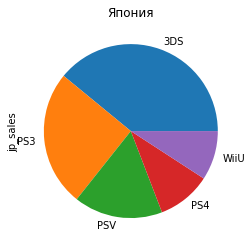

In [84]:
(
    df.groupby('platform')['jp_sales'].sum()
    .sort_values(ascending=False)
    .head()
    .plot(kind='pie', grid=True, title='Япония')
);

По круговым диаграммам заметно значительное различие в долях продаж по разным регионам.

- **В Северной Америке доминируют платформы семейства Xbox - X360 и XOne - на них приходится порядка 42 % рынка**. Далее располагаются платформы семейства PS - PS3 и PS4 - на них приходится 32 % рынка. Замыкает топ 5 платформа WiiU с 8 %.
- **В Европе доминируют платформы семейства PS - PS4 и PS3 - на них приходится порядка 31 % рынка, а также платформы семейства Xbox - X360 и XOne - на них приходится 27 % рынка**. Также значительную долю рынка занимает PC - порядка 10 %.
- **В Японии доминирует местная платформа 3DS: она занимает 35 % рынка**. Далее следуют платформы семейства PS - PS3, PSV и PS4 - на них приходится 46 % рынка. В конце топа располагается платформа WiiU с 8 %.

####  Топ 5 популярных жанров

Выведем топ 5 жанров по количеству проданных копий игр для Северной Америки, Европы и Японии.

In [85]:
print('Северная Америка')

display(
    df.groupby('genre')['na_sales'].sum()
    .sort_values(ascending=False)
    .head()
)

print('Европа')

display(
    df.groupby('genre')['eu_sales'].sum()
    .sort_values(ascending=False)
    .head()
)

print('Япония')

(
    df.groupby('genre')['jp_sales'].sum()
    .sort_values(ascending=False)
    .head()
)

Северная Америка


genre
Action          139.029999
Shooter          87.050003
Sports           72.860001
Role-Playing     41.950001
Misc             24.930000
Name: na_sales, dtype: float32

Европа


genre
Action          114.040001
Shooter          65.580002
Sports           37.910000
Role-Playing     29.690001
Racing           25.139999
Name: eu_sales, dtype: float32

Япония


genre
Action          45.259998
Role-Playing    40.299999
Misc            12.700000
Adventure        8.240000
Sports           7.690000
Name: jp_sales, dtype: float32

Посчитаем доли продаж для топ 5 жанров относительно всего регионального рынка для Северной Америки, Европы и Японии.

In [86]:
print('Северная Америка')

display(
    (df.groupby('genre')['na_sales'].sum()
    .sort_values(ascending=False)
    .head()) * 100 /
    df['na_sales'].sum()
)

print('Европа')

display(
    (df.groupby('genre')['eu_sales'].sum()
    .sort_values(ascending=False)
    .head()) * 100 /
    df['eu_sales'].sum()
)

print('Япония')

display(
    (df.groupby('genre')['jp_sales'].sum()
    .sort_values(ascending=False)
    .head()) * 100 /
    df['jp_sales'].sum()
)

Северная Америка


genre
Action          31.742008
Shooter         19.874430
Sports          16.634703
Role-Playing     9.577625
Misc             5.691781
Name: na_sales, dtype: float32

Европа


genre
Action          33.220695
Shooter         19.103939
Sports          11.043463
Role-Playing     8.648916
Racing           7.323468
Name: eu_sales, dtype: float32

Япония


genre
Action          31.443657
Role-Playing    27.997776
Misc             8.823121
Adventure        5.724607
Sports           5.342504
Name: jp_sales, dtype: float32

Также выведем круговые диаграммы топ 5 жанров по количеству проданных копий игр для Северной Америки, Европы и Японии.

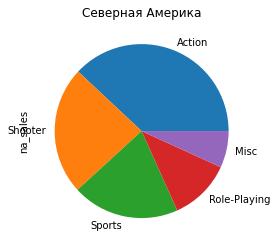

In [87]:
(
    df.groupby('genre')['na_sales'].sum()
    .sort_values(ascending=False)
    .head()
    .plot(kind='pie', grid=True, title='Северная Америка')
);

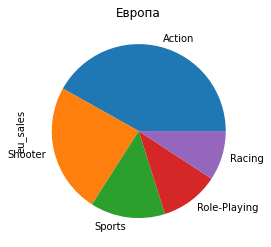

In [88]:
(
    df.groupby('genre')['eu_sales'].sum()
    .sort_values(ascending=False)
    .head()
    .plot(kind='pie', grid=True, title='Европа')
);

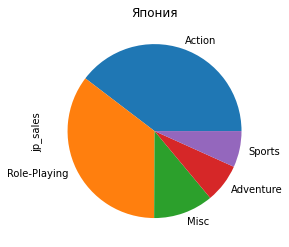

In [89]:
(
    df.groupby('genre')['jp_sales'].sum()
    .sort_values(ascending=False)
    .head()
    .plot(kind='pie', grid=True, title='Япония')
);

**Во всех регионах доминирующим жанром является action**, притом в каждом регионе он охватывает схожие доли рынка:
- 32 % в Северной Америке;
- 33 % в Европе;
- 31 % в Японии.

Далее заметны различия между Северной Америкой и Европой с одной стороны, и Японией с другой.

В первых двух регионах жанры топ 4 полностью совпадают, незначительно отличаются лишь доли рынка. Посмотрим на топ 5:
- Shooter: 20 % в Северной Америке и 19 % в Европе;
- Sports: 17 % / 11 %;
- Role-Playing: 10 % / 9 %;
- Misc: 6 % в Северной Америке / racing: 7 % в Европе.

В Японии помимо action в топ 5 также входят:
- Role-Playing: 28 %;
- Misc: 9 %;
- Adventure: 6 %;
- Sports: 5 %.

Разницу в предпочтении жанров между пользователями из евроатлантических государств и Японии можно объяснить разным мировосприятием - принято считать, что люди из Европы и Америки и люди из Японии ментально отдалены друг от друга.

Популярность жанра Role-Playing в Японии также может быть связана с этим фактором: считается, что жители страны восходящего солнца любят косплеи, что может быть связано с предпочтением ими жанра Role-Playing.

БОльшую долю жанра sports в Северной Америке в сравнении с Европой можно объяснить любовью американцев США и канадцев к спорту.

#### Влияние рейтингов ESRB на продажи

Опишем значения столбца rating - рейтинги ESRB:
- «E» («Everyone») — «Для всех»
- «E10+» («Everyone 10 and older») — «Для всех от 10 лет и старше»
- «T» («Teen») — «Подросткам» (от 13 лет и старше)
- «M» («Mature») — «Для взрослых» (от 17 лет и старше)

Выведем топ значений рейтингов по количеству проданных копий игр для Северной Америки, Европы и Японии.

In [90]:
print('Северная Америка')

display(
    df.groupby('rating')['na_sales'].sum()
    .sort_values(ascending=False)
)

print('Европа')

display(
    df.groupby('rating')['eu_sales'].sum()
    .sort_values(ascending=False)
)

print('Япония')

(
    df.groupby('rating')['jp_sales'].sum()
    .sort_values(ascending=False)
)

Северная Америка


rating
M       153.149994
E        97.320000
E10+     69.419998
T        59.220001
Name: na_sales, dtype: float32

Европа


rating
M       121.430000
E        66.400002
E10+     52.740002
T        46.250000
Name: eu_sales, dtype: float32

Япония


rating
T       23.040001
E       19.719999
M       16.510000
E10+     8.160000
Name: jp_sales, dtype: float32

Посчитаем доли продаж для каждого рейтинга для Северной Америки, Европы и Японии.

In [91]:
print('Северная Америка')

display(
    (df.groupby('rating')['na_sales'].sum()
    .sort_values(ascending=False)) * 100 /
    df.loc[~df['rating'].isna(), 'na_sales'].sum()
)

print('Европа')

display(
    (df.groupby('rating')['eu_sales'].sum()
    .sort_values(ascending=False)) * 100 /
    df.loc[~df['rating'].isna(), 'eu_sales'].sum()
)

print('Япония')

display(
    (df.groupby('rating')['jp_sales'].sum()
    .sort_values(ascending=False)) * 100 /
    df.loc[~df['rating'].isna(), 'jp_sales'].sum()
)

Северная Америка


rating
M       40.397243
E       25.670650
E10+    18.311308
T       15.620796
Name: na_sales, dtype: float32

Европа


rating
M       42.336655
E       23.150408
E10+    18.387838
T       16.125095
Name: eu_sales, dtype: float32

Япония


rating
T       34.168766
E       29.245142
M       24.484652
E10+    12.101439
Name: jp_sales, dtype: float32

Также выведем круговые диаграммы топ рейтингов по количеству проданных копий игр для Северной Америки, Европы и Японии.

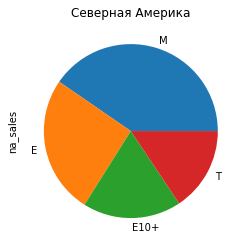

In [92]:
(
    df.groupby('rating')['na_sales'].sum()
    .sort_values(ascending=False)
    .plot(kind='pie', grid=True, title='Северная Америка')
);

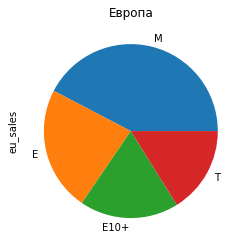

In [93]:
(
    df.groupby('rating')['eu_sales'].sum()
    .sort_values(ascending=False)
    .plot(kind='pie', grid=True, title='Европа')
);

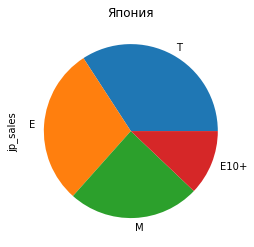

In [94]:
(
    df.groupby('rating')['jp_sales'].sum()
    .sort_values(ascending=False)
    .plot(kind='pie', grid=True, title='Япония')
);

При оценке долей продаж игр разных категорий налицо значительные различия между Северной Америкой и Европой с одной стороны, и Японией с другой.

Круговые диаграммы для первых двух регионов практически одинаковы:
- рейтинг M: 40 % рынка в Северной Америке и 42 % в Европе;
- рейтинг E: 26 % / 23 %;
- рейтинг E10+: 18 % / 19 %;
- рейтинг T: 16 % / 16 %.

Для Японии значения совсем иные:
- рейтинг T: 34 % рынка в Японии;
- рейтинг E: 29 %;
- рейтинг M: 25 %;
- рейтинг E10+: 12 %.

Разницу в предпочтении игр с определенными рейтингами между пользователями из евроатлантических государств и Японии можно объяснить двумя причинами:
- как и для предыдущего вывода, разное мировосприятие;
- считается, что взрослые люди в Японии очень много работают. Возможно, в связи с этим доля игр для взрослых составляет в стране восходящего солнца лишь 25 % в сравнении со средним евроатлантическим 41 %.

## Проверка гипотез

### Первая проверка

Первое утверждение звучит так: средние пользовательские рейтинги платформ Xbox One и PC одинаковые.

Сформулируем нулевую и альтернативную гипотезы.
- Нулевая гипотеза:
 - средний пользовательский рейтинг платформы Xbox One **равен** среднему пользовательскому рейтингу платформы PC
- Альтернативная двусторонняя гипотеза:
 - средний пользовательский рейтинг платформы Xbox One **не равен** среднему пользовательскому рейтингу платформы PC

Проверим нулевую гипотезу.

In [95]:
# сохраним строки датафрейма с ненулевыми значениями рейтинга пользователей для платформы XOne

xone_user_scores = (
    df[(df['platform'] == 'XOne') & \
       (df['user_score'] > 0)] \
    ['user_score']
)

In [96]:
# сохраним строки датафрейма с ненулевыми значениями рейтинга пользователей для PC

pc_user_scores = (
    df[(df['platform'] == 'PC') & \
       (df['user_score'] > 0)] \
    ['user_score']
)

In [97]:
# выведем длины полученных сириэс

print(len(xone_user_scores))

len(pc_user_scores)

179


205

Т.к. объем выборки измеряется сотнями, примем критический уровень статистической значимости равный [0.01](https://www.statmethods.ru/stati/vybor-urovnya-znachimosti-pri-proverke-statisticheskikh-gipotez/).

In [98]:
# назначим значение критического уровня статистической значимости 

alpha = .01

Для проверки гипотезы проведем t-тест. Т.к. нам необходимо проверить равенство средних двух независимых совокупностей, то воспользуемся методом st.ttest_ind.

Прежде чем перейти к непосредственному проведению t-теста, проверим, равняются ли дисперсии двух выборок.

In [99]:
np.var(xone_user_scores, ddof=1) == np.var(pc_user_scores, ddof=1)

False

Дисперсии не равны, следовательно, передадим параметру equal_var метода ttest_ind аргумент False.

In [100]:
# проверим гипотезу о равенстве среднего двух независимых совокупностей

results = st.ttest_ind(
    xone_user_scores, 
    pc_user_scores,
    equal_var = False)

In [101]:
# выведем p-значение

print('p-значение:', results.pvalue)

p-значение: 0.5584708790819752


In [102]:
# проверим нулевую гипотезу

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу.')
else:
    print('Не получилось отвергнуть нулевую гипотезу.')

Не получилось отвергнуть нулевую гипотезу.


**Мы не можем отвергнуть нулевую гипотезу, которая звучит так: средний пользовательский рейтинг платформы Xbox One равен среднему пользовательскому рейтингу платформы PC.
Следовательно, средние пользовательские рейтинги игр на платформах Xbox One и PC примерно одинаковые**.

Ввиду того, что данные платформы значительно отличаются как технически, так и по своему функционалу - XOne является консольной приставкой, а PC означает не что иное, как персональный компьютер - мы можем сделать вывод о том, что совпадение средних пользовательских оценок для игр данных платформ случайно, и не говорит о наличии какой-либо взаимосвязи между играми для данных платформ.

### Вторая проверка

Второе утверждение звучит так: средние пользовательские рейтинги жанров action и sports разные.

Сформулируем нулевую и альтернативную гипотезы.
- Нулевая гипотеза:
 - средний пользовательский рейтинг жанра action **не равен** среднему пользовательскому рейтингу жанра sports
- Альтернативная двусторонняя гипотеза:
 - средний пользовательский рейтинг жанра action **равен** среднему пользовательскому рейтингу жанра sports

Проверим нулевую гипотезу.

In [103]:
# сохраним строки датафрейма с ненулевыми значениями рейтинга пользователей для жанра action

action_user_scores = (
    df[(df['genre'] == 'Action') & \
       (df['user_score'] > 0)] \
    ['user_score']
)

In [104]:
# сохраним строки датафрейма с ненулевыми значениями рейтинга пользователей для жанра sports

sports_user_scores = (
    df[(df['genre'] == 'Sports') & \
       (df['user_score'] > 0)] \
    ['user_score']
)

In [105]:
# выведем длины полученных сириэс

print(len(action_user_scores))

len(sports_user_scores)

512


186

Т.к. объем выборки измеряется сотнями, примем критический уровень статистической значимости равный 0.01.

In [106]:
# назначим значение критического уровня статистической значимости 

alpha = .01

Для проверки гипотезы проведем t-тест. Т.к. нам необходимо проверить равенство средних двух независимых совокупностей, то воспользуемся методом st.ttest_ind.

Прежде чем перейти к непосредственному проведению t-теста, проверим, равняются ли дисперсии двух выборок.

In [107]:
np.var(action_user_scores, ddof=1) == np.var(sports_user_scores, ddof=1)

False

Дисперсии не равны, следовательно, передадим параметру equal_var метода ttest_ind аргумент False.

In [108]:
# проверим гипотезу о равенстве среднего двух независимых совокупностей

results = st.ttest_ind(
    action_user_scores, 
    sports_user_scores,
    equal_var = False)

In [109]:
# выведем p-значение

print('p-значение:', results.pvalue)

p-значение: 4.771573856139866e-18


In [110]:
# проверим нулевую гипотезу

if results.pvalue == alpha:
    print('Отвергаем нулевую гипотезу.')
else:
    print('Не получилось отвергнуть нулевую гипотезу.')

Не получилось отвергнуть нулевую гипотезу.


**Мы не можем отвергнуть нулевую гипотезу, которая звучит так: средний пользовательский рейтинг жанра action не равен среднему пользовательскому рейтингу жанра sports.
Следовательно, средние пользовательские рейтинги игр в жанрах action и sports существенно различаются**. В некоторой степени такой результат соответствует ожиданиям: данные жанры, несмотря на некоторые общие особенности (например, динамичность), технически значительно отличаются.

## Общий вывод

На основе входных данных о продажах игр, оценках пользователей и экспертов, жанрах и платформах был проведен ряд исследовательских анализов и исследований. Целью общего исследования было выявление закономерностей, определяющих успешность игры, что в дальнейшем позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

**Анализ релиза игр по годам**.

Результаты анализа:
- в датафрейме представлены данные о релизах игр с 1980 по 2016 года включительно;
- наибольшее количество игр было выпущено в 2009 году - почти 1500, наименьшее - в 1980 - 9;
- среднее количество игр, выпущенных за один год, составляет 444;
- медианное количество игр, выпущенных за один год, составляет 336;
- в 80-е годы было выпущено 182 игры, в 90-е - 1389, в 00-е - 7418, с 2010 по 2016 года - 3484.

Выводы из анализа:
- начиная с 2002 года заметен скачок количества выпущенных за год игр: вплоть до 2011 года этот параметр составляет не менее 750;
- кроме того, в период с 2002 по 2011 года были выпущены две трети игр;
- до 2011 года включительно наблюдается тенденция к увеличению количества выпущенных за год игр, после - тенденция к уменьшению;
- в связи с полученными данными можно выделить 5 временных периодов:
 - 1980-1993 - период становления игровой индустрии: ежегодно выходят не более 60 игр;
 - 1994-2001 - период бурного роста: количество выпускаемых игр увеличивается со 118 до 477;
 - 2002-2009 - "золотой" период индустрии: в год выпускается не менее 750 игр, в период с 2005 года - не менее 800, с 2007 - не менее 1000; пик приходится на 2009 год - почти 1.5 тысячи выпущенных игр;
 - 2010-2011 - период плавного спада: за 2010 год выходит менее 1300 игр, за 2011 - менее 1200;
 - 2012-2016 - период резкого спада: в 2012 году выходит 641 игра, далее - менее 600 игр в год.
 
**Анализ продаж по платформам**.

Результаты анализа:
- был выведен топ платформ с наибольшими суммарными продажами игр и построен график распределения по платформам;
- средние года релиза для 10 из топ 11 таких платформ лежат в промежутке между 2003 и 2011 годами - в этот период было выпущено подавляющее большинство игр;
- были построены графики распределения по годам для платформ с количеством проданных копий игр более 500 миллионов;
- пики на графиках для всех таких платформ, кроме PS, приходятся на период с 2003 по 2011 года, когда было выпущено преобладающее число игр.

Выводы из анализа:
- между количеством проданных копий игры и платформой выхода игры наблюдается связь, которая, тем не менее, обязана своему существованию наличию взаимосвязи между платформой релиза и годом выхода игры;
- в данных наблюдается характерный срок, когда появляются новые платформы и исчезают старые: этот срок составляет 8-11 лет.

**Определение актуального периода**.

По результатам проведения данных анализов был принят актуальный период - промежуток с 2012 по 2016 год включительно. Основные критерии принятия данного временного отрезка в качестве актуального периода:
- года внутри данного промежутка находятся вместе с прогнозируемым 2017 годом в одном периоде (из вывода анализа релиза игр по годам), а именно в периоде резкого спада: 2012-2016;
- года внутри промежутка должны стать годами первых релизов игр на новых платформах - это связано с тем, что срок появления и исчезновения платформ составляет 8-11 лет.

На основе данных за соответствующий актуальный период можно будет сделать прогноз на 2017 год, т.к:
- года будет принадлежать одному периоду развития индустрии, следовательно, релизы и продажи должны будут осуществляться по одному закону;
- в 2017 году продолжат выходить игры на новых платформах, срок жизни которых еще не истечет.

После определения актуального периода датафрейм был перезаписан: в нем остались данные исключительно за данный временной промежуток.

**Исследование прибыльности платформ**.

Результаты исследования:
- был выведен топ оставшихся в датафрейме платформ с наибольшими суммарными продажами игр и построены графики распределения по платформам: столбчатая и круговая диаграммы;
- были построены графики распределения по годам для платформ с количеством проданных копий игр более 50 миллионов. Следует уточнить, что ввиду общего падения игровой индустрии в течение актуального периода было принято решение о построении графиков не по абсолютным величинам продаж, а по доле продаж по годам;

Выводы из исследования:
- среди всех оставшихся в датафрейме платформ были определены лидеры продаж: платформы с числом продаж более 50 миллионов копий;
- представленные платформы были разбиты на 3 условные группы: платформы, жизненный цикл которых подходит к концу - продажи падают; платформы, жизненный цикл которых берет свое начало - продажи растут; платформы, для которых не наблюдается четкой тенденции к падению или росту продаж;
- были определены потенциально прибыльные платформы: оные, относящиеся к группе роста продаж, а именно PS4 и XOne.

**Анализ характера разброса данных**.

В ходе анализа были построены диаграммы размаха ("ящики с усами") по продажам игр для каждой платформы. 

Результаты анализа:
- медианы продаж игр для платформ лежат в интервале от 30 тысяч до 290 тысяч;
- первые квартили находятся достаточно близко друг к другу: наименьшее значение составляет 20 тысяч, наибольшее - 100 тысяч;
- третьи квартили достаточно широко разбросаны: наименьшее значение - 90 тысяч, наибольшее - 790 тысяч;
- распределение границ статистически значимой выборки имеет схожую с распределением квартилей природу: нижние границы расположены близко друг к другу, верхние - разбросаны и находятся в промежутке между ~180 тысячами и 1750 тысячми;
- для всех платформ наблюдаются выбросы: для PSP все они лежат в интервале до 500 тысяч, для WiiU, X360 и XOne отдельные значения превышают 5 миллионов;
- данные для некоторых платформ (PSP, PSV, DS) сгруппированы достаточно плотно, для других (X360, Wii, XOne) - достаточно широко разбросаны;
- для графиков всех платформ характерна асимметрия - медиана значительно ближе расположена к первому квартилю, нежели к третьему.

Вывод из анализа:
- данные смещены в сторону нижней границы значений.

**Исследование влияния отзывов пользователей и критиков на продажи**.

Результаты исследования:
- для каждой пары параметров - общие продажи-оценка критиков и общие продажи-оценка пользователей - были построены диаграммы рассеяния для случайной популярной растущей платформы (PS4), а также были рассчитаны коэффициенты корреляции;
- коэффициент корреляции Пирсона для пары параметров: общие продажи-оценка критиков составляет 33 процента, что говорит о наличии умеренной связи. Однако данный показатель достаточно мал для того, чтобы сделать вывод о наличии высокой или хотя бы заметной связи между исследуемыми параметрами;
- коэффициент корреляции Пирсона для пары параметров: общие продажи-оценка пользователей составляет 0.4 процента, что говорит либо об отсутствии взаимосвязи между исследуемыми параметрами, либо о ее более сложном характере;
- аналогичные коэффициенты корреляции для данных для платформы PS4 не сильно отличаются от оных, рассчитанных ранее.

Вывод:
- утверждать о влиянии отзывов пользователей и критиков на продажи нельзя.

**Исследование прибыльности жанров**.

Результаты исследования:
- был выведен топ жанров с наибольшим количеством выпущенных игр и построен график распределения по жанрам;
- лидером среди жанров по количеству игр оказался action: на него приходится более 1000 наименований; на следующие следом за ним Role-Playing, Adventure, Sports и Shooter приходятся от 360 до 220 игр соответственно;
- внизу топа оказались жанры Puzzle, Strategy и Simulation с 28, 71 и 80 выпущенными играми соответственно;
- был выведен топ жанров с наибольшими суммарными продажами игр и построен график распределения по жанрам;
- в данных по продажам игр среди всех жанров лидирует action: в мире продано более 330 миллионов копий игр данного жанра; также более 100 миллионов копий игр продано для жанров Shooter, Sports и Role-Playing (180, 135 и 120 миллионов соответственно);
- внизу данного топа расположились жанры Puzzle, Strategy и Simulation с 5, 13 и 21 миллионом проданных копий соответственно.

Выводы из исследования:
- наблюдается зависимость между количеством выпущенных игр и их суммарными продажами;
- среди жанров выделяются как оные с высокими продажами, так и с низкими;
- к группе жанров с высоким уровнем продаж относятся:
 - Action
 - Shooter
 - Sports
 - Role-Playing
- к группе жанров с низким уровнем продаж относятся:
 - Puzzle
 - Strategy
 - Simulation
 
**Исследование пользователей по регионам**.

- топ 5 платформ по продажам

 - В Северной Америке доминируют платформы семейства Xbox - X360 и XOne - на них приходится порядка 42 % рынка. Далее располагаются платформы семейства PS - PS3 и PS4 - на них приходится 32 % рынка. Замыкает топ 5 платформа WiiU с 8 %.
 - В Европе доминируют платформы семейства PS - PS4 и PS3 - на них приходится порядка 31 % рынка, а также платформы семейства Xbox - X360 и XOne - на них приходится 27 % рынка. Также значительную долю рынка занимает PC - порядка 10 %.
 - В Японии доминирует местная платформа 3DS: она занимает 35 % рынка. Далее следуют платформы семейства PS - PS3, PSV и PS4 - на них приходится 46 % рынка. В конце топа располагается платформа WiiU с 8 %;
 
- топ 5 жанров по продажам
 - во всех регионах доминирующим жанром является action, притом в каждом регионе он охватывает схожие доли рынка (в среднем 32 %);
 - далее между Северной Америкой и Европой с одной стороны, и Японией с другой заметны различия: в евроатлантических странах большей популярностью пользуются шутеры и спортивные игры (притом последние более популярны в Северной Америке), в Японии - ролевые игры;
 - разницу в предпочтении жанров между пользователями из евроатлантических государств и Японии можно объяснить разным мировосприятием - принято считать, что люди из Европы и Америки и люди из Японии ментально отдалены друг от друга;
 - популярность ролевого жанра в Японии также может быть связана с любовью жителей страны к косплеям;
 - бОльшую долю жанра sports в Северной Америке в сравнении с Европой можно объяснить любовью американцев США и канадцев к спорту;

- влияние рейтингов ESRB на продажи
 - налицо значительные различия между Северной Америкой и Европой с одной стороны, и Японией с другой;
 - круговые диаграммы для Северной Америки и Европы практически одинаковы, незначительно отличаются лишь доли рынка;
 - в евроатлантических странах наиболее хорошо продаются игры для взрослых, в Японии - для тинэйджеров;
 - возможно, что различие в долях рынка для евроатлантики и Японии связана с тем, что, как считается, взрослые люди в Японии очень много работают, и, следовательно, не находят времени на игры.
 
**Проверка гипотез**

На основании **первого утверждения**: средние пользовательские рейтинги платформ Xbox One и PC одинаковые, были сформулированы нулевая и альтернативная гипотезы:
- средний пользовательский рейтинг платформы Xbox One **равен** среднему пользовательскому рейтингу платформы PC;
- средний пользовательский рейтинг платформы Xbox One **не равен** среднему пользовательскому рейтингу платформы PC.

По результатам проверки гипотезы мы не смогли отвергнуть нулевую гипотезу. Это значит, что средние пользовательские рейтинги игр на платформах Xbox One и PC примерно одинаковые.

Скорее всего, совпадение средних пользовательских оценок для игр данных платформ случайно, и не говорит о наличии какой-либо взаимосвязи между играми для данных платформ.

На основании **второго утверждения**: средние пользовательские рейтинги жанров action и sports разные, были сформулированы нулевая и альтернативная гипотезы:
- средний пользовательский рейтинг жанра action **не равен** среднему пользовательскому рейтингу жанра sports;
- средний пользовательский рейтинг жанра action **равен** среднему пользовательскому рейтингу жанра sports.

По результатам проверки гипотезы мы не смогли отвергнуть нулевую гипотезу. Это значит, что средние пользовательские рейтинги игр в жанрах action и sports существенно различаются. 

В некоторой степени такой результат соответствует ожиданиям: данные жанры, несмотря на некоторые общие особенности (например, динамичность), технически значительно отличаются.
 
**Общие рекомендации**:

Целью исследований было выявление закономерностей, определяющих успешность игры, что в дальнейшем позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании. К таким закономерностям можно отнести следующие:
- потенциально прибыльные платформы: оные, относящиеся к группе роста продаж, а именно PS4 и XOne;
- потенциально прибыльные жанры: оные, относящиеся к группе с высоким уровнем продаж, а именно: Action, Shooter, Sports и Role-Playing.

Кроме того, следует также учитывать, что пользователи из разных регионов различаются между собой, следовательно, при планировании рекламных кампаний необходимо учитывать особенности конкретного региона, а именно:
- в Северной Америке доминируют платформы семейства Xbox;
- в Европе однозначного доминанта нет: широко распространены как платформы семейства PS, так и платформы семейства Xbox;
- в Японии доминирует местная платформа 3DS;
- в евроатлантических странах большей популярностью пользуются шутеры и спортивные игры (притом последние более популярны в Северной Америке), в Японии - ролевые игры;
- в евроатлантических странах наиболее хорошо продаются игры для взрослых, в Японии - для тинэйджеров.

Данные параметры следует учитывать для того, чтобы сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.